[nltk_data] Downloading package punkt to /Users/gavin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DatasetDict({
    train: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 2717
    })
})
使用设备: mps


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 108.90it/s]


Epoch 1/20 | Train Loss: 2.0312 | Val Loss: 1.3491 | Val Acc: 0.5575 | Val F1: 0.5291
 Validation loss decreased to 1.3491. Saving model...


Epoch 2/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 115.90it/s]


Epoch 2/20 | Train Loss: 1.1200 | Val Loss: 0.9889 | Val Acc: 0.6819 | Val F1: 0.6780
 Validation loss decreased to 0.9889. Saving model...


Epoch 3/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 113.33it/s]


Epoch 3/20 | Train Loss: 0.8380 | Val Loss: 0.9012 | Val Acc: 0.7056 | Val F1: 0.6995
 Validation loss decreased to 0.9012. Saving model...


Epoch 4/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 115.28it/s]


Epoch 4/20 | Train Loss: 0.6741 | Val Loss: 0.8562 | Val Acc: 0.7244 | Val F1: 0.7279
 Validation loss decreased to 0.8562. Saving model...


Epoch 5/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.41it/s]


Epoch 5/20 | Train Loss: 0.5365 | Val Loss: 0.8396 | Val Acc: 0.7344 | Val F1: 0.7330
 Validation loss decreased to 0.8396. Saving model...


Epoch 6/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.74it/s]


Epoch 6/20 | Train Loss: 0.4291 | Val Loss: 0.8934 | Val Acc: 0.7344 | Val F1: 0.7352
 EarlyStopping counter: 1/5


Epoch 7/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.99it/s]


Epoch 7/20 | Train Loss: 0.3405 | Val Loss: 0.9263 | Val Acc: 0.7362 | Val F1: 0.7357
 EarlyStopping counter: 2/5


Epoch 8/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.09it/s]


Epoch 8/20 | Train Loss: 0.2670 | Val Loss: 0.9740 | Val Acc: 0.7400 | Val F1: 0.7459
 EarlyStopping counter: 3/5


Epoch 9/20: 100%|████████████████████████████| 400/400 [00:03<00:00, 114.38it/s]


Epoch 9/20 | Train Loss: 0.1506 | Val Loss: 0.9698 | Val Acc: 0.7531 | Val F1: 0.7544
 EarlyStopping counter: 4/5


Epoch 10/20: 100%|███████████████████████████| 400/400 [00:03<00:00, 113.54it/s]


Epoch 10/20 | Train Loss: 0.1170 | Val Loss: 0.9812 | Val Acc: 0.7556 | Val F1: 0.7565
 EarlyStopping counter: 5/5
 触发 Early Stopping。停止训练。
 加载最佳模型权重。
 最佳模型已保存为 bilstm_relation_extractor_best.pt


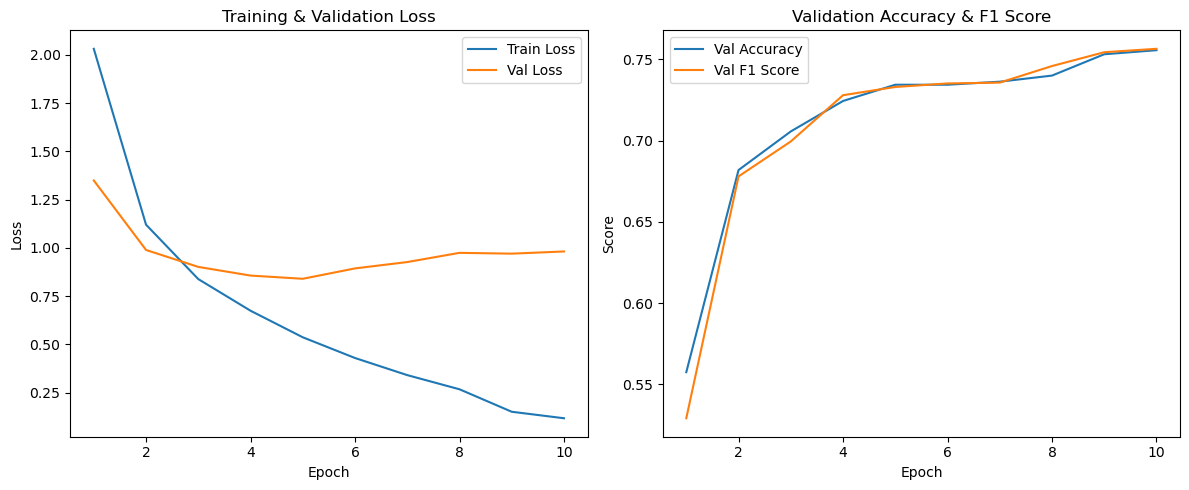

In [6]:
# 安装 Huggingface datasets 库
!pip install datasets matplotlib seaborn

# 导入库
from datasets import load_dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import copy

nltk.download('punkt')
from nltk.tokenize import word_tokenize

# 1️ 加载 SemEval-2010 Task 8 数据集
dataset = load_dataset("SemEvalWorkshop/sem_eval_2010_task_8")
print(dataset)

# 2️ 数据预处理
class SemEvalDataset(Dataset):
    def __init__(self, sentences, labels, word2idx, max_len=50):
        self.sentences = sentences
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx].replace('<e1>', ' <e1> ').replace('</e1>', ' </e1> ')
        sentence = sentence.replace('<e2>', ' <e2> ').replace('</e2>', ' </e2> ')
        tokens = word_tokenize(self.sentences[idx].lower())
        seq = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        if len(seq) < self.max_len:
            seq += [self.word2idx['<PAD>']] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        return torch.tensor(seq), torch.tensor(self.labels[idx])

# 3️ 加载 GloVe 词向量
def load_glove_embeddings(glove_file, word2idx, embedding_dim=300):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    embeddings[word2idx['<PAD>']] = np.zeros(embedding_dim)
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# 4️ BiLSTM 模型（增加 Dropout）
class BiLSTMRelationExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embeddings):
        super(BiLSTMRelationExtractor, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,  
    bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)  # 拼接 avg_pool 和 max_pool
        self.dropout = nn.Dropout(0.5)  # 增加 Dropout 防止过拟合

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.bilstm(x)
        avg_pool = torch.mean(lstm_out, 1)
        max_pool, _ = torch.max(lstm_out, 1)
        out = torch.cat((avg_pool, max_pool), 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# 5️ EarlyStopping 机制
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
            if self.verbose:
                print(f" Validation loss decreased to {val_loss:.4f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f" EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# 6️ 主程序
if __name__ == '__main__':

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载数据
    sentences = dataset['train']['sentence']
    labels = dataset['train']['relation']

    # 构建词表
    all_tokens = [word_tokenize(s.lower()) for s in sentences]
    vocab = {word for tokens in all_tokens for word in tokens}
    word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = 1
    

    # 加载 GloVe 词向量
    embedding_dim = 300
    glove_path = 'glove.6B.300d.txt'  # 确保文件存在
    embeddings = load_glove_embeddings(glove_path, word2idx, embedding_dim)

    # 数据集与 DataLoader
    X_train, X_val, y_train, y_val = train_test_split(sentences, labels, test_size=0.2, random_state=42)
    train_dataset = SemEvalDataset(X_train, y_train, word2idx)
    val_dataset = SemEvalDataset(X_val, y_val, word2idx)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # 初始化模型
    hidden_dim = 128
    output_dim = 19  # SemEval-2010 Task 8 有 19 类
    model = BiLSTMRelationExtractor(len(word2idx), embedding_dim, hidden_dim, output_dim, embeddings)
    model = model.to(device)

    # 损失函数 & 优化器（增加 L2 正则化）
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 正则化

    # 学习率动态调整器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

    # EarlyStopping
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # 记录结果用于可视化
    train_losses, val_losses = [], []
    val_accuracies, val_f1_scores = [],[]

    # 训练模型
    epochs = 20
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证集评估
        model.eval()
        y_true, y_pred = [], []
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_batch.cpu().tolist())
                y_pred.extend(predicted.cpu().tolist())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='weighted')
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        # 打印结果
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val F1: {val_f1:.4f}")

        # 调整学习率
        scheduler.step(avg_val_loss)

        # EarlyStopping 检查
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(" 触发 Early Stopping。停止训练。")
            break

    # 载入最佳模型
    model.load_state_dict(early_stopping.best_model_state)
    print(" 加载最佳模型权重。")
    torch.save(model.state_dict(), 'bilstm_relation_extractor_best.pt')
    print(" 最佳模型已保存为 bilstm_relation_extractor_best.pt")

    # 可视化训练结果
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # 准确率 & F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.plot(epochs_range, val_f1_scores, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Accuracy & F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

使用设备: mps


/var/folders/g7/xh9qh0js6qvg0d5lb8c7n3lc0000gn/T/ipykernel_61209/2543561747.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bilstm_rel

 测试集准确率: 0.7361
 测试集 F1 分数: 0.7339

 分类报告:
                           precision    recall  f1-score   support

            Cause-Effect       0.95      0.87      0.91       134
       Instrument-Agency       0.92      0.87      0.89       194
        Product-Producer       0.78      0.80      0.79       162
       Content-Container       0.70      0.71      0.70       150
           Entity-Origin       0.79      0.86      0.82       153
      Entity-Destination       0.74      0.72      0.73        39
         Component-Whole       0.85      0.87      0.86       291
       Member-Collection       0.00      0.00      0.00         1
           Message-Topic       0.81      0.81      0.81       211
                   Other       0.81      0.83      0.82        47
     Cause-Effect(e1,e2)       0.39      0.50      0.44        22
     Cause-Effect(e2,e1)       0.69      0.72      0.71       134
Instrument-Agency(e1,e2)       0.63      0.53      0.58        32
Instrument-Agency(e2,e1)       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


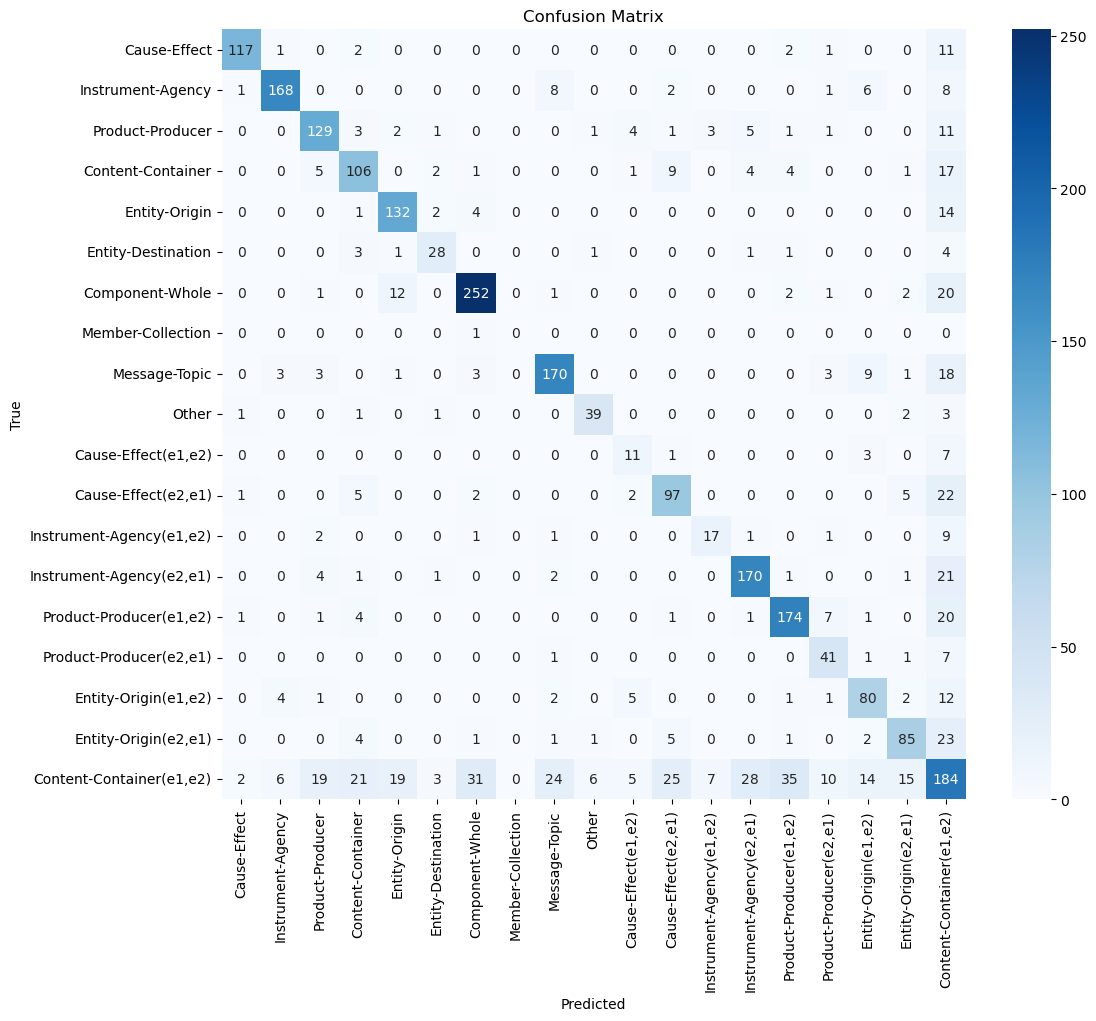

In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    """
    在给定的 dataloader 上评估模型，返回真实标签和预测标签。
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(y_batch.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())

    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    绘制混淆矩阵
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def test_model():
    # 设备选择
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载词表、测试集和模型
    glove_path = 'glove.6B.300d.txt'  # 确保 GloVe 文件路径正确
    embedding_dim = 300

    # 加载 GloVe 词向量
    embeddings = load_glove_embeddings(glove_path, word2idx, embedding_dim)

    # 初始化模型
    hidden_dim = 128
    output_dim = 19  # SemEval-2010 Task 8 有 19 类
    model = BiLSTMRelationExtractor(len(word2idx), embedding_dim, hidden_dim, output_dim, embeddings)
    model.load_state_dict(torch.load('bilstm_relation_extractor_best.pt'))  # 加载已保存的最优模型
    model = model.to(device)

    # 创建测试集 DataLoader
    test_sentences = dataset['test']['sentence']
    test_labels = dataset['test']['relation']
    test_dataset = SemEvalDataset(test_sentences, test_labels, word2idx)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # 评估模型
    y_true, y_pred = evaluate_model(model, test_loader, device)

    # 计算准确率和 F1 分数
    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f" 测试集准确率: {test_acc:.4f}")
    print(f" 测试集 F1 分数: {test_f1:.4f}")
    print("\n 分类报告:\n", classification_report(y_true, y_pred, target_names=[
        "Cause-Effect", "Instrument-Agency", "Product-Producer", "Content-Container", "Entity-Origin",
        "Entity-Destination", "Component-Whole", "Member-Collection", "Message-Topic", "Other", 
        "Cause-Effect(e1,e2)", "Cause-Effect(e2,e1)", "Instrument-Agency(e1,e2)", "Instrument-Agency(e2,e1)", 
        "Product-Producer(e1,e2)", "Product-Producer(e2,e1)", "Entity-Origin(e1,e2)", "Entity-Origin(e2,e1)", 
        "Content-Container(e1,e2)"
    ]))

    # 绘制混淆矩阵
    plot_confusion_matrix(y_true, y_pred, class_names=[
        "Cause-Effect", "Instrument-Agency", "Product-Producer", "Content-Container", "Entity-Origin",
        "Entity-Destination", "Component-Whole", "Member-Collection", "Message-Topic", "Other", 
        "Cause-Effect(e1,e2)", "Cause-Effect(e2,e1)", "Instrument-Agency(e1,e2)", "Instrument-Agency(e2,e1)", 
        "Product-Producer(e1,e2)", "Product-Producer(e2,e1)", "Entity-Origin(e1,e2)", "Entity-Origin(e2,e1)", 
        "Content-Container(e1,e2)"
    ])

test_model()